In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb

Load Preprocessed Data

In [2]:
#load cleaned dataset
df= pd.read_parquet("cleaned_data.parquet")
df.head()

,ffb_1%_oer,import,export,production,end_stock,cpo_futures,usd_myr_rate,brent_oil_futures,soybean_futures,precipitation,...,avg_humidity,lag_1,lag_3,lag_7,rolling_mean_7,rolling_mean_30,rolling_std_7,rolling_std_30,pct_change_1,pct_change_7
0,21.2,81477,1680891,1737461,3002871,2204.0,4.1075,61.65,30.74,20.6,...,88.041667,21.25,20.85,20.60,20.992857,20.533333,0.212972,0.319032,-0.002353,0.029126
1,21.3,81477,1680891,1737461,3002871,2200.0,4.0960,61.89,30.48,47.5,...,90.083333,21.20,21.20,20.75,21.071429,20.576667,0.209875,0.332113,0.004717,0.026506
2,21.3,94278,1324615,1544518,3056929,2200.0,4.0960,62.75,30.21,7.0,...,89.958333,21.30,21.25,20.85,21.135714,20.620000,0.199404,0.339015,0.000000,0.021583
3,21.3,94278,1324615,1544518,3056929,2200.0,4.0960,62.75,30.21,4.7,...,90.083333,21.30,21.20,20.85,21.200000,20.660000,0.160728,0.346261,0.000000,0.021583
4,21.3,94278,1324615,1544518,3056929,2200.0,4.0960,62.75,30.21,13.2,...,89.125000,21.30,21.30,20.85,21.264286,20.690000,0.047559,0.361606,0.000000,0.021583


In [3]:
target_col = "ffb_1%_oer"
raw_features = ["import", "export", "production", "end_stock", 
                "cpo_futures", "usd_myr_rate", "brent_oil_futures", 
                "soybean_futures", "precipitation", "avg_temperature", "avg_humidity"]

engineered_features = ["lag_1","lag_3","lag_7","rolling_mean_7",
                       "rolling_mean_30","rolling_std_7","rolling_std_30",
                       "pct_change_1","pct_change_7"]

engineered_features_lstm = ["lag_1", "rolling_mean_7"]

X = df[raw_features + engineered_features].values
y = df[target_col].values.reshape(-1,1)


#Splitting into train-validate-test dataa
N = len(df)
train_size = int(N * 0.7)   # 70% train
val_size   = int(N * 0.2)  # 20% validation
test_size  = N - train_size - val_size  # 10% test

X_train_raw = X[:train_size]
X_val_raw   = X[train_size:train_size+val_size]
X_test_raw  = X[train_size+val_size:]

y_train_raw = y[:train_size]
y_val_raw   = y[train_size:train_size+val_size]
y_test_raw  = y[train_size+val_size:]


#scale data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_x.fit_transform(X_train_raw)
X_val   = scaler_x.transform(X_val_raw)
X_test  = scaler_x.transform(X_test_raw)

y_train = scaler_y.fit_transform(y_train_raw)
y_val   = scaler_y.transform(y_val_raw)
y_test  = scaler_y.transform(y_test_raw)

LSTM:

2.1 Prepare Data for LSTM

In [4]:
#create sequences for LSTM input using lookback=90
def create_sequences(X,y,lookback):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

lookback = 90
X_train_lstm, y_train_lstm = create_sequences(X_train, y_train, lookback)
X_val_lstm, y_val_lstm = create_sequences(X_val, y_val, lookback)
X_test_lstm, y_test_lstm = create_sequences(X_test, y_test, lookback)




2.2 Build LSTM Model

In [5]:
from tensorflow.keras import backend as K
import tensorflow as tf
import random
from tensorflow.keras.callbacks import EarlyStopping

#clear previous models/graphs
K.clear_session()

#fix random seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(lookback,X_train.shape[1])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

#EarlyStopping Callback
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 15,
    restore_best_weights=True
)

history = model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

y_pred_lstm = model.predict(X_test_lstm)
y_pred_lstm_inv = scaler_y.inverse_transform(y_pred_lstm)
y_test_lstm_inv = scaler_y.inverse_transform(y_test_lstm)


Epoch 1/50


c:\Users\User\Desktop\test2\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0104 - val_loss: 0.0011
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0045 - val_loss: 6.8510e-04
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0025 - val_loss: 6.1617e-04
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0027 - val_loss: 6.3427e-04
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0024 - val_loss: 6.6699e-04
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0022 - val_loss: 8.6238e-04
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0020 - val_loss: 8.3352e-04
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/ste

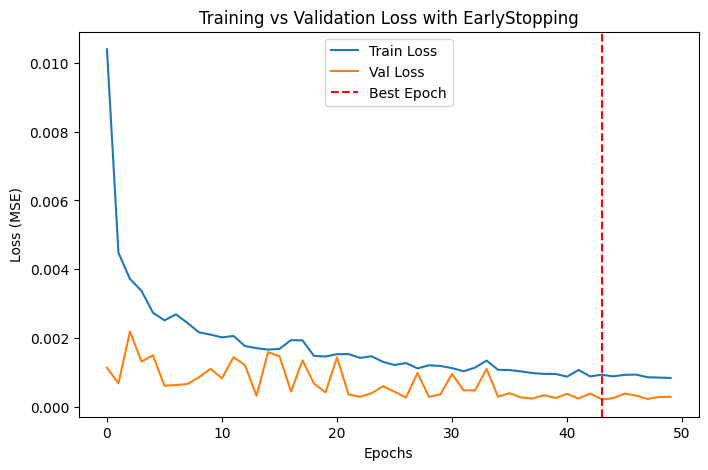

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.axvline(np.argmin(history.history['val_loss']), color='r', linestyle='--', label='Best Epoch')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.title("Training vs Validation Loss with EarlyStopping")
plt.show()


2.3 Evaluate LSTM Model

RMSE: 1.9267
MAE: 1.5191
MAPE: 3.2453
R^2: 0.7531


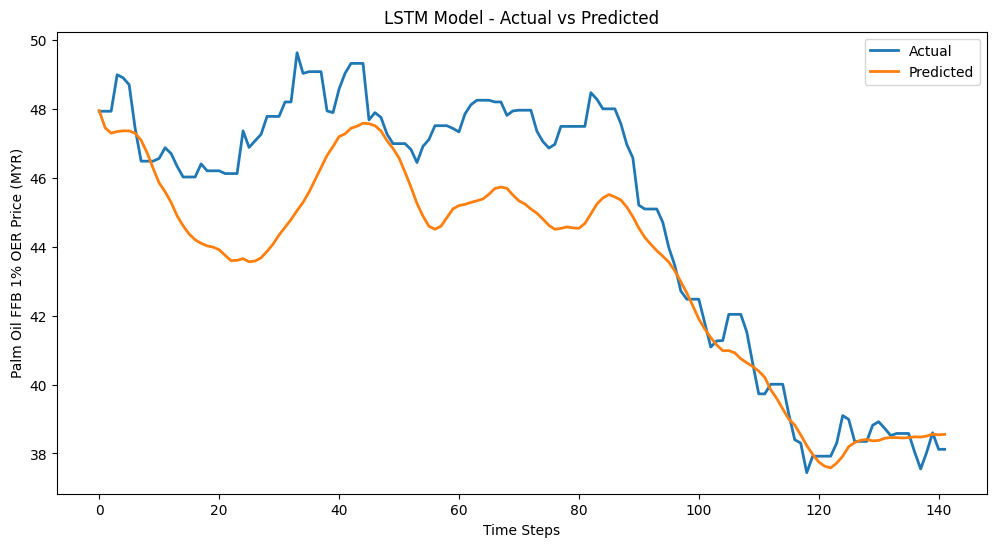

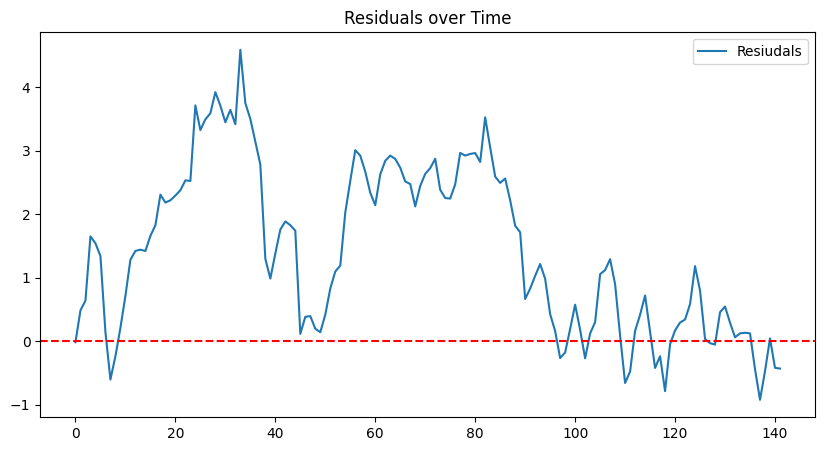

In [7]:
#evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_lstm_inv, y_pred_lstm_inv))
mae = mean_absolute_error(y_test_lstm_inv, y_pred_lstm_inv)
mape = np.mean(np.abs((y_test_lstm_inv - y_pred_lstm_inv)/ y_test_lstm_inv)) * 100
r2 = r2_score(y_test_lstm_inv, y_pred_lstm_inv)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R^2: {r2:.4f}")

#visualization
plt.figure(figsize=(12,6))
plt.plot(y_test_lstm_inv, label="Actual", linewidth=2)
plt.plot(y_pred_lstm_inv, label="Predicted", linewidth=2)
plt.title("LSTM Model - Actual vs Predicted")
plt.xlabel("Time Steps")
plt.ylabel("Palm Oil FFB 1% OER Price (MYR)")
plt.legend()
plt.show()

#residual analysis
residuals = y_test_lstm_inv - y_pred_lstm_inv
plt.figure(figsize=(10,5))
plt.plot(residuals, label="Resiudals")
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals over Time")
plt.legend()
plt.show()



XGBOOST 

In [8]:
xgb_features_idx = [(raw_features + engineered_features).index(f) for f in engineered_features ]

X_train_xgb = X_train[:,xgb_features_idx]
X_val_xgb = X_val[:,xgb_features_idx]
X_test_xgb = X_test[:,xgb_features_idx]

dtrain = xgb.DMatrix(X_train_xgb, label= y_train)
dval = xgb.DMatrix(X_val_xgb, label= y_val)
dtest = xgb.DMatrix(X_test_xgb, label= y_test)

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.1,
    "max_depth": 5
}

xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=[(dtrain, "train"), (dval, "val")],
    early_stopping_rounds = 20,
    verbose_eval=50
)

y_pred_xgb = xgb_model.predict(dtest)
y_pred_xgb_inv = scaler_y.inverse_transform(y_pred_xgb.reshape(-1,1))
y_test_inv = scaler_y.inverse_transform(y_test)

[0]	train-rmse:0.19329	val-rmse:0.03706
[50]	train-rmse:0.00304	val-rmse:0.00406
[58]	train-rmse:0.00248	val-rmse:0.00416


In [8]:
xgb_model.save_model("xgb_model1.json")

Hybrid Fusion (Using Simple Average)

In [ ]:
"""
# Ensure 1D arrays for metrics
y_pred_lstm_inv = y_pred_lstm_inv.flatten()
y_test_lstm_inv = y_test_lstm_inv.flatten()
y_pred_xgb_inv = y_pred_xgb_inv.flatten()
y_test_inv = y_test_inv.flatten()

min_len = min(len(y_pred_lstm_inv), len(y_pred_xgb_inv))
y_pred_hybrid = (y_pred_lstm_inv[-min_len:] + y_pred_xgb_inv[-min_len:])/2
y_true_hybrid = y_test_inv[-min_len]
"""


In [ ]:
"""
# Ensure 1D shape
y_pred_lstm_inv = y_pred_lstm_inv.ravel()
y_pred_xgb_inv = y_pred_xgb_inv.ravel()
y_test_inv = y_test_inv.ravel()

# Align lengths
min_len = min(len(y_pred_lstm_inv), len(y_pred_xgb_inv), len(y_test_inv))

# Adjust model weight
w_lstm = 0.4
w_xgboost = 0.6

#if using weight:
y_pred_hybrid = w_lstm*y_pred_lstm_inv[-min_len:] + w_xgboost*y_pred_xgb_inv[-min_len:]

#y_pred_hybrid = (y_pred_lstm_inv[-min_len:] + y_pred_xgb_inv[-min_len:]) / 2
y_true_hybrid = y_test_inv[-min_len:]

# Evaluate
print("HYBRID:", eval_metrics(y_true_hybrid, y_pred_hybrid))
"""



HYBRID: (np.float64(0.8072718497227206), 0.6354908967353933, np.float64(1.3585513576655346), 0.9566538756846307)


Using error-based weights to do hybrid model fusion:

In [12]:
# Ensure 1D shape
y_pred_lstm_inv = y_pred_lstm_inv.ravel()
y_pred_xgb_inv = y_pred_xgb_inv.ravel()
y_test_inv = y_test_inv.ravel()

# Align lengths
min_len = min(len(y_pred_lstm_inv), len(y_pred_xgb_inv), len(y_test_inv))
y_true_hybrid = y_test_inv[-min_len:]

error_lstm = np.mean((y_pred_lstm_inv[-min_len:] - y_true_hybrid)**2)
error_xgb = np.mean((y_pred_xgb_inv[-min_len:] - y_true_hybrid)**2)
w_lstm = 1/error_lstm
w_xgb = 1/error_xgb
w_sum = w_lstm + w_xgb
y_pred_hybrid = (w_lstm * y_pred_lstm_inv[-min_len:] + w_xgb * y_pred_xgb_inv[-min_len:]) / w_sum
#y_true_hybrid = y_test_inv[-min_len:]

# Evaluate
print("HYBRID:", eval_metrics(y_true_hybrid, y_pred_hybrid))

HYBRID: (np.float64(0.3940079332159766), 0.28096642718067316, np.float64(0.6054546027504291), 0.9896742742100969)


In [ ]:
"""
print("Next day forecasted FFB 1% OER Price:", y_pred_hybrid[-1])

import pandas as pd

df_forecast = pd.DataFrame({
    "Actual": y_true_hybrid,
    "LSTM": y_pred_lstm_inv[-min_len:],
    "XGBoost": y_pred_xgb_inv[-min_len:],
    "Hybrid": y_pred_hybrid
})

print(df_forecast.head())
df_forecast.to_csv("forecast_results.csv", index=False)
"""


Next day forecasted FFB 1% OER Price: 38.09051078637948
   Actual       LSTM    XGBoost     Hybrid
0   47.94  47.959202  48.425716  48.406193
1   47.94  47.458897  47.973064  47.951547
2   47.94  47.303505  47.973064  47.945044
3   49.00  47.351147  49.506264  49.416075
4   48.91  47.371082  47.973064  47.947872


Evaluation

In [11]:
def eval_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, mape, r2

print("LSTM:", eval_metrics(y_test_lstm_inv, y_pred_lstm_inv))
print("XGBOOST:", eval_metrics(y_test_inv, y_pred_xgb_inv))
print("HYBRID:", eval_metrics(y_true_hybrid, y_pred_hybrid))

LSTM: (np.float64(1.9266627003581063), 1.5191365115743292, np.float64(9.493898745307087), 0.75309946303098)
XGBOOST: (np.float64(0.8435442436433117), 0.4207292589648019, np.float64(0.8707187176030673), 0.9596763645764194)
HYBRID: (np.float64(0.3940079332159766), 0.28096642718067316, np.float64(0.6054546027504291), 0.9896742742100969)


In [ ]:
"""
def eval_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    # Safe MAPE (ignore zeros in denominator)
    nonzero_idx = y_true != 0
    mape = np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, mape, r2

print("LSTM:", eval_metrics(y_test_lstm_inv, y_pred_lstm_inv))
print("XGBOOST:", eval_metrics(y_test_inv, y_pred_xgb_inv))
print("HYBRID:", eval_metrics(y_true_hybrid, y_pred_hybrid))
"""


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

RESULT VISUALIZATIONS:

5.1 Error Comparison Bar Chart

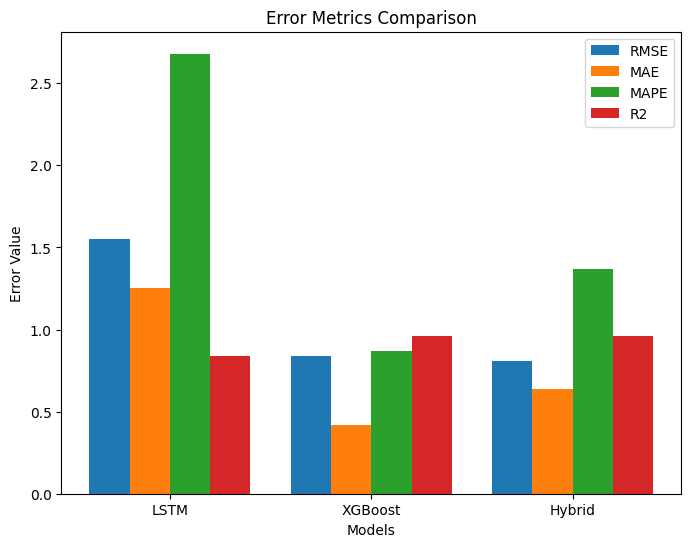

In [ ]:
"""

import matplotlib.pyplot as plt
import numpy as np

models = ["LSTM", "XGBoost", "Hybrid"]

rmse = [1.55, 0.84, 0.81]
mae = [1.25, 0.42, 0.64]
mape = [2.68, 0.87, 1.37]
r2 = [0.84, 0.96, 0.96]

x = np.arange(len(models))
width = 0.20

fig, ax = plt.subplots(figsize=(8,6))

ax.bar(x - 1.5*width, rmse, width, label='RMSE')
ax.bar(x - 0.5*width, mae, width, label='MAE')
ax.bar(x + 0.5*width, mape, width, label='MAPE')
ax.bar(x + 1.5*width, r2, width, label='R2')

ax.set_xlabel("Models")
ax.set_ylabel("Error Value")
ax.set_title("Error Metrics Comparison")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()
"""


5.2 Forecast Vs Actual line Plot

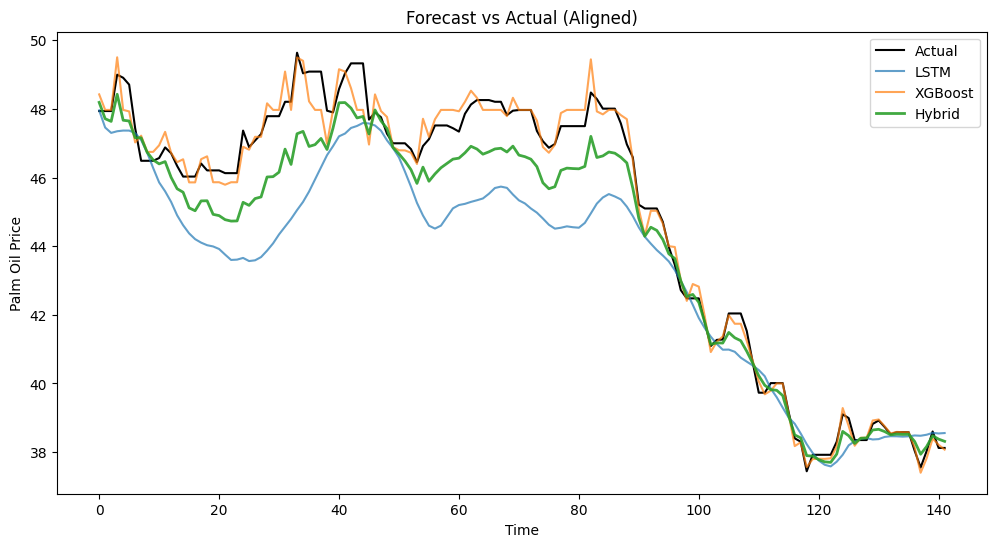

In [13]:
# Align lengths for fair comparison
min_len = min(len(y_pred_lstm_inv), len(y_pred_xgb_inv), len(y_test_inv))

y_true_plot   = y_test_inv[-min_len:]
y_lstm_plot   = y_pred_lstm_inv[-min_len:]
y_xgb_plot    = y_pred_xgb_inv[-min_len:]
y_hybrid_plot = (y_lstm_plot + y_xgb_plot) / 2

# Plot
plt.figure(figsize=(12,6))
plt.plot(y_true_plot, label="Actual", color="black")
plt.plot(y_lstm_plot, label="LSTM", alpha=0.7)
plt.plot(y_xgb_plot, label="XGBoost", alpha=0.7)
plt.plot(y_hybrid_plot, label="Hybrid", alpha=0.9, linewidth=2)

plt.xlabel("Time")
plt.ylabel("Palm Oil Price")
plt.title("Forecast vs Actual (Aligned)")
plt.legend()
plt.show()


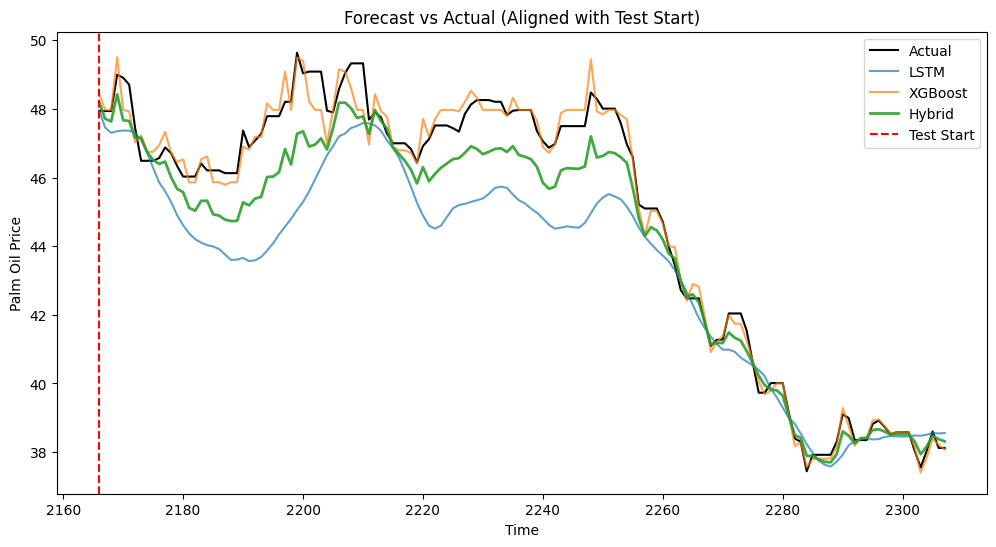

In [14]:
# Align lengths for fair comparison
min_len = min(len(y_pred_lstm_inv), len(y_pred_xgb_inv), len(y_test_inv))

y_true_plot   = y_test_inv[-min_len:]
y_lstm_plot   = y_pred_lstm_inv[-min_len:]
y_xgb_plot    = y_pred_xgb_inv[-min_len:]
y_hybrid_plot = (y_lstm_plot + y_xgb_plot) / 2

# Index offset for plotting test set in full timeline
test_start_index = train_size + val_size + lookback  # account for LSTM lookback shift

# Create time axis
time_axis = np.arange(test_start_index, test_start_index + min_len)

# Plot
plt.figure(figsize=(12,6))
plt.plot(time_axis, y_true_plot, label="Actual", color="black")
plt.plot(time_axis, y_lstm_plot, label="LSTM", alpha=0.7)
plt.plot(time_axis, y_xgb_plot, label="XGBoost", alpha=0.7)
plt.plot(time_axis, y_hybrid_plot, label="Hybrid", alpha=0.9, linewidth=2)

# Vertical line marking test start
plt.axvline(x=test_start_index, color="red", linestyle="--", linewidth=1.5, label="Test Start")

plt.xlabel("Time")
plt.ylabel("Palm Oil Price")
plt.title("Forecast vs Actual (Aligned with Test Start)")
plt.legend()
plt.show()


5.3 Residual Error Distribution Plot

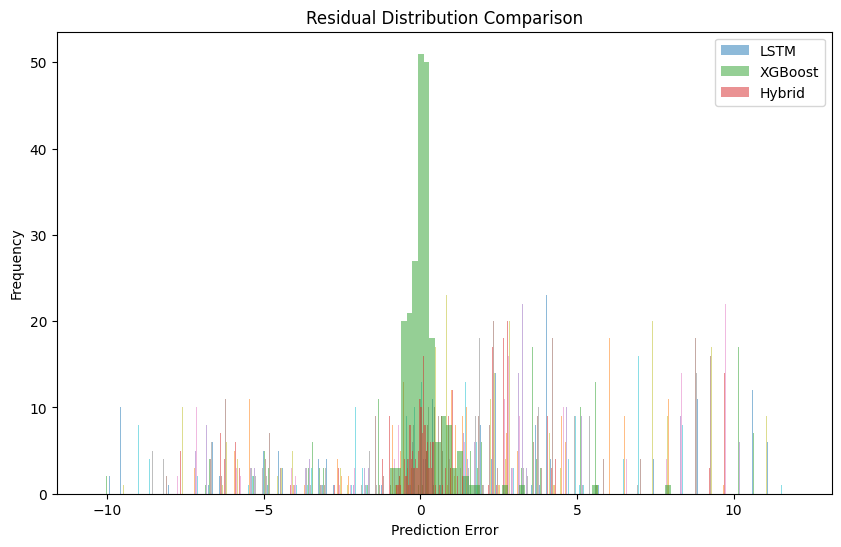

In [15]:
plt.figure(figsize=(10,6))
plt.hist(y_test_lstm_inv - y_pred_lstm_inv, bins=50, alpha=0.5, label="LSTM")
plt.hist(y_test_inv - y_pred_xgb_inv, bins=50, alpha=0.5, label="XGBoost")
plt.hist(y_true_hybrid - y_pred_hybrid, bins=50, alpha=0.5, label="Hybrid")

plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Residual Distribution Comparison")
plt.legend()
plt.show()


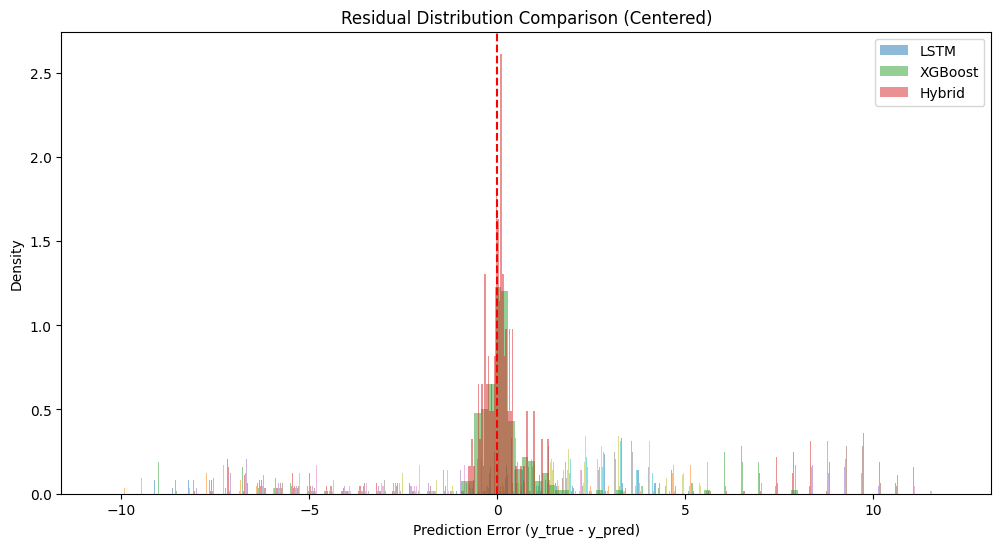

In [16]:
plt.figure(figsize=(12,6))

plt.hist(y_test_lstm_inv - y_pred_lstm_inv, bins=50, alpha=0.5, label="LSTM", density=True)
plt.hist(y_test_inv - y_pred_xgb_inv, bins=50, alpha=0.5, label="XGBoost", density=True)
plt.hist(y_true_hybrid - y_pred_hybrid, bins=50, alpha=0.5, label="Hybrid", density=True)

plt.axvline(0, color="red", linestyle="--", linewidth=1.5)  # zero-error line

plt.xlabel("Prediction Error (y_true - y_pred)")
plt.ylabel("Density")
plt.title("Residual Distribution Comparison (Centered)")
plt.legend()
plt.show()


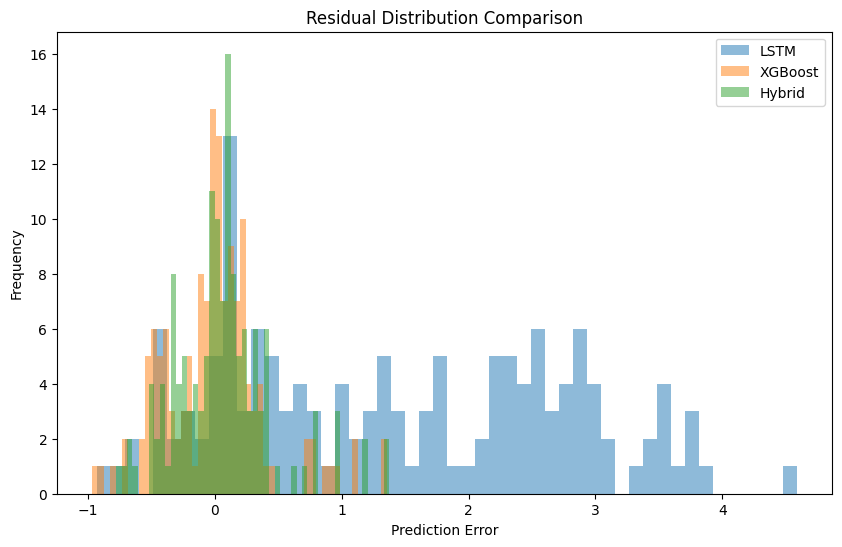

In [17]:
# Assuming y_test_inv is your correctly inverse-transformed test set ground truth
min_len = min(len(y_pred_lstm_inv), len(y_pred_xgb_inv), len(y_pred_hybrid))
y_true_aligned = y_test_inv[-min_len:]

plt.figure(figsize=(10,6))
plt.hist(y_true_aligned - y_pred_lstm_inv[-min_len:], bins=50, alpha=0.5, label="LSTM")
plt.hist(y_true_aligned - y_pred_xgb_inv[-min_len:], bins=50, alpha=0.5, label="XGBoost")
plt.hist(y_true_aligned - y_pred_hybrid[-min_len:], bins=50, alpha=0.5, label="Hybrid")

plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Residual Distribution Comparison")
plt.legend()
plt.show()

In [18]:
forecast_horizon = [7,14,28]

#Helper: Update Engineered Features

def update_features(history, new_value):
    history = history.append(pd.Series([new_value]), ignore_index=True)

    features = {
        "lag_1": history.iloc[-1],
        "lag_3": history.iloc[-3] if len(history) >= 3 else history.iloc[0],
        "lag_7": history.iloc[-7] if len(history) >= 7 else history.iloc[0],
        "rolling_mean_7": history.rolling(7).mean().iloc[-1],
        "rolling_mean_30": history.rolling(30).mean().iloc[-1],
        "rolling_std_7": history.rolling(7).std().iloc[-1],
        "rolling_std_30": history.rolling(30).std().iloc[-1],
        "pct_change_7": history.pct_change(1).iloc[-1],
        "pct_change_30": history.pct_change(7).iloc[-1] if len(history)>=7 else 0
    }
    return features, history


#Multi step hybrid forecast
def forecast_hybrid (lstm_model, xgb_model, scaler_y, X_test_lstm, X_test_xgb, y_test_inv, w_lstm, w_xgb):
    forecast = {}

    for horizon in forecast_horizon:
        lstm_forecast = []
        xgb_forecast = []
        hybrid_forecast = []

        #Initialize LSTM input (last sequence of test set)
        lstm_input = X_test_lstm[-1].reshape(1, lookback, X_test_lstm.shape[2])

        #Initialize XGB input (last row of test set)
        last_row = X_test_xgb[-1].copy()

        #History of actual values (inverse transformed)
        history = pd.Series(list(y_test_inv))

        for step in range(horizon):
            #--LSTM--
            lstm_pred_scaled = lstm_model.predict(lstm_input)
            lstm_pred = scaler_y.inverse_transform(lstm_pred_scaled)[0][0]
            lstm_forecast.append(lstm_pred)

            #Update LSTM input with new prediction
            new_input = np.append(lstm_input[:,1:,:],
                                  lstm_pred_scaled.reshape(1,1,-1), axis=1)
            lstm_input = new_input

            #--XGBoost--
            dlast = xgb.DMatrix(last_row.reshape(1,-1))
            xgb_pred_scaled = xgb_model.predict(dlast)
            xgb_pred = scaler_y.inverse_transform(xgb_pred_scaled.reshape(-1,1))[0][0]
            xgb_forecast.append(xgb_pred)

            #update features with new XGB prediction
            new_features, history = update_features(history, xgb_pred)
            last_row = np.array(list(new_features.values()))

            #--Hybrid(error-based weights)--
            hybrid_pred = (w_lstm * lstm_pred + w_xgb * xgb_pred) / (w_lstm + w_xgb)
            hybrid_forecast.append(hybrid_pred)

        forecast[horizon] = {
            "LSTM": lstm_forecast,
            "XGBoost": xgb_forecast,
            "Hybrid": hybrid_forecast
        }

    return forecast

#Run Multi-step forecast
results = forecast_hybrid(
    lstm_model=model,
    xgb_model=xgb_model,
    scaler_y=scaler_y,
    X_test_lstm=X_test_lstm,
    X_test_xgb=X_test_xgb,
    y_test_inv=y_test_inv,
    w_lstm=w_lstm,
    w_xgb=w_xgb
)

#Save Results
for horizon in forecast_horizon:
    df_out = pd.DataFrame(results[horizon])
    df_out.to_csv(f"forecast_{horizon}d.csv", index=False)
    print(f"\nForecast for {horizon} days ahead: ")
    print(df_out.head())
        



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 20 and the array at index 1 has size 1

In [ ]:
def forecast_hybrid(lstm_model, xgb_model, scaler_y, df, raw_features, engineered_features, forecast_horizon=[7,14,28]):
    """
    Multi-step hybrid forecast (autoregressive)
    """
    results = {}

    # Start from last known values
    history = df.copy()

    for horizon in forecast_horizon:
        preds = []
        
        for step in range(horizon):
            # --- Prepare features for XGBoost ---
            # Recompute engineered features dynamically
            temp_df = history.copy()
            for lag in [1,3,7]:
                temp_df[f"lag_{lag}"] = temp_df[target_col].shift(lag)
                temp_df["rolling_mean_7"] = temp_df[target_col].rolling(7).mean()
                temp_df["rolling_mean_30"] = temp_df[target_col].rolling(30).mean()
                temp_df["rolling_std_7"] = temp_df[target_col].rolling(7).std()
                temp_df["rolling_std_30"] = temp_df[target_col].rolling(30).std()
                temp_df["pct_change_1"] = temp_df[target_col].pct_change(1)
                temp_df["pct_change_7"] = temp_df[target_col].pct_change(7)
                temp_df = temp_df.dropna()

            latest_features = temp_df[raw_features + engineered_features].iloc[-1:].values
            latest_features_scaled = scaler_x.transform(latest_features)
            dmatrix = xgb.DMatrix(latest_features_scaled[:, [(raw_features + engineered_features).index(f) for f in engineered_features]])
            
            xgb_pred = xgb_model.predict(dmatrix)[0]
            xgb_pred_inv = scaler_y.inverse_transform([[xgb_pred]])[0,0]

            # --- LSTM prediction ---
            # Use last `lookback` window
            X_lstm_scaled = scaler_x.transform(history[raw_features + engineered_features].values)
            X_seq = []
            for i in range(len(X_lstm_scaled) - lookback, len(X_lstm_scaled)):
                X_seq.append(X_lstm_scaled[i])
            X_seq = np.array(X_seq).reshape(1, lookback, -1)

            lstm_pred = lstm_model.predict(X_seq, verbose=0)[0,0]
            lstm_pred_inv = scaler_y.inverse_transform([[lstm_pred]])[0,0]

            # --- Hybrid weighted ---
            hybrid_pred = (w_lstm * lstm_pred_inv + w_xgb * xgb_pred_inv) / (w_lstm + w_xgb)
            preds.append(hybrid_pred)

            # --- Update history with prediction ---
            new_row = history.iloc[-1:].copy()
            new_row[target_col] = hybrid_pred
            history = pd.concat([history, new_row], ignore_index=True)

        results[horizon] = preds
    
    return results


In [20]:
forecast_results = forecast_hybrid(
    lstm_model=model,
    xgb_model=xgb_model,
    scaler_y=scaler_y,
    df=df,
    raw_features=raw_features,
    engineered_features=engineered_features,
    forecast_horizon=[7,14,28]
)

for h, preds in forecast_results.items():
    print(f"Next {h} days forecast:", preds)


Next 7 days forecast: [np.float64(38.087199932506365), np.float64(38.0834064082551), np.float64(38.08025921677127), np.float64(38.07811154625838), np.float64(38.07696956558354), np.float64(38.07669065053972), np.float64(38.07707920691453)]
Next 14 days forecast: [np.float64(38.07793429414413), np.float64(38.07907323151121), np.float64(38.08034319561519), np.float64(38.08162492169241), np.float64(38.08283327937709), np.float64(38.08391299562015), np.float64(38.08483470661427), np.float64(38.08558903568147), np.float64(38.08618116467011), np.float64(38.08662573435806), np.float64(38.086942814126246), np.float64(38.0871547763993), np.float64(38.08728358234404), np.float64(38.08734946584452)]
Next 28 days forecast: [np.float64(38.08737019323792), np.float64(38.08736024079902), np.float64(38.08733120599795), np.float64(38.08729164299704), np.float64(38.08724804966963), np.float64(38.087204620845355), np.float64(38.08716407082571), np.float64(38.08712779788725), np.float64(38.08709646004245)